<a href="https://colab.research.google.com/github/EmiTR/MasterProject-ET/blob/main/ET_MNIST_GAN_WithText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement Generative Adversarial Nets (GAN) from [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf). 

The dataset I use for this notebook and for other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU

# Setup

In [ ]:
# Packages for GAN
import torchvision.transforms as transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch
import torchvision

# Supporting packages
import numpy as np
from time import time
import matplotlib.pyplot as plt

GAN is very sensitive to changes of hyperparameter. Try diffirent combinations for better results!

In [ ]:
DIM = 10
NUM_EPOCHS = 100 #try 200, 400 or 600 for better results
BATCH_SIZE = DIM*DIM
LEARNING_RATE = 0.0002 #try diffirent learning rate 
Z_DIM = 100 #also try 28, 64, etc.
HIDDEN_DIM = 64
IMG_SIZE = 28 
IM_CHANNELS = 1 #MNIST data is black and white > channel = 1. For colored images: channels = 3
img_shape = (IM_CHANNELS, IMG_SIZE, IMG_SIZE) #1,28,28

In [ ]:
#checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Getting data

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    datasets.MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Generator Model

**Each layer of generator:**

*   Fully connected with other layers
*   Uses Linear(input, output) and LeakyReLU(0.2, inplace=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, Z_DIM=100, HIDDEN_DIM=64, OUT_CHANNEL=1):
        super(Generator, self).__init__()
        def block_generator(Z_DIM, HIDDEN_DIM, normalize=True): 
            layers = [nn.Linear(Z_DIM, HIDDEN_DIM)]
            if normalize:
                layers.append(nn.BatchNorm1d(HIDDEN_DIM, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block_generator(Z_DIM, HIDDEN_DIM*2, normalize=False),
            *block_generator(HIDDEN_DIM*2, HIDDEN_DIM*4),
            *block_generator(HIDDEN_DIM*4, HIDDEN_DIM*8),
            *block_generator(HIDDEN_DIM*8, HIDDEN_DIM*16),
            nn.Linear(HIDDEN_DIM*16, int(np.prod(img_shape))),
            nn.Tanh() #[-1,1] for input and output
        )
    def forward(self, z):
        img = self.model(z)
        img=img.view(img.size(0), *img_shape)
        return img

# Discriminator Model

**Each layer of discriminator:**


*   Convolution for downsampling
*   Use batchnorm except for the last layer
*   Apply LeakyReLU activation with slope of 0.2 for all layers 




In [ ]:
class Discriminator(nn.Module):
    def __init__(self, IM_CHANNEL=1, HIDDEN_DIM=64): 
        super(Discriminator, self).__init__()
        #can also use function to create block here.
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), HIDDEN_DIM*8),
            nn.LeakyReLU(0.2, inplace=True), #try 0.1 also 
            nn.Linear(HIDDEN_DIM*8, HIDDEN_DIM*4),
            nn.LeakyReLU(0.2, inplace=True), #try 0.1 also 
            nn.Linear(HIDDEN_DIM*4, 1),
            nn.Sigmoid(),
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Start Training

In [ ]:
criterion = torch.nn.BCELoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE) #no need for betas.
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE) #actually no need for betas.
Tensor = torch.cuda.FloatTensor if torch.cuda else torch.FloatTensor
generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
saved_imgs = []
for epoch in range(NUM_EPOCHS):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        
        #Tranining Generator
        generator_optimizer.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], Z_DIM)))) #noise
        gen_imgs = generator(z)
        generator_loss = criterion(discriminator(gen_imgs), real)
        #Calculating generator's gradient
        generator_loss.backward()
        #Updating generator's optimizer
        generator_optimizer.step()

        # Training Discriminator
        discriminator_optimizer.zero_grad()
        real_loss = criterion(discriminator(real_imgs),real)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        discriminator_loss = (real_loss + fake_loss) / 2
        #Calculating discriminator's gradient
        discriminator_loss.backward()
        #Updating discriminator's optimizer
        discriminator_optimizer.step()

    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=DIM)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch 0 training... done, took 18.2 seconds.
Epoch 1 training... done, took 17.7 seconds.
Epoch 2 training... done, took 17.2 seconds.
Epoch 3 training... done, took 17.1 seconds.
Epoch 4 training... done, took 21.7 seconds.
Epoch 5 training... done, took 18.2 seconds.
Epoch 6 training... done, took 20.5 seconds.
Epoch 7 training... done, took 17.0 seconds.
Epoch 8 training... done, took 17.3 seconds.
Epoch 9 training... done, took 17.8 seconds.
Epoch 10 training... done, took 17.4 seconds.
Epoch 11 training... done, took 17.6 seconds.
Epoch 12 training... done, took 18.0 seconds.
Epoch 13 training... done, took 17.4 seconds.
Epoch 14 training... done, took 17.2 seconds.
Epoch 15 training... done, took 17.2 seconds.
Epoch 16 training... done, took 17.1 seconds.
Epoch 17 training... done, took 17.2 seconds.
Epoch 18 training... done, took 17.2 seconds.
Epoch 19 training... done, took 17.1 seconds.
Epoch 20 training... done, took 17.2 seconds.
Epoch 21 training... done, took 17.1 seconds

# Visualization

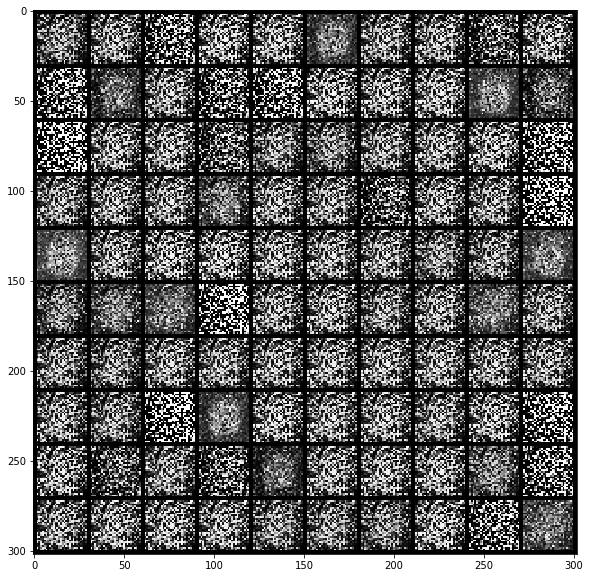

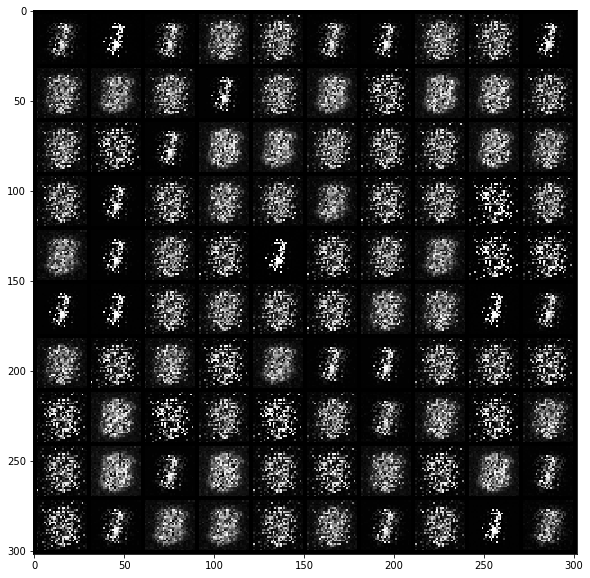

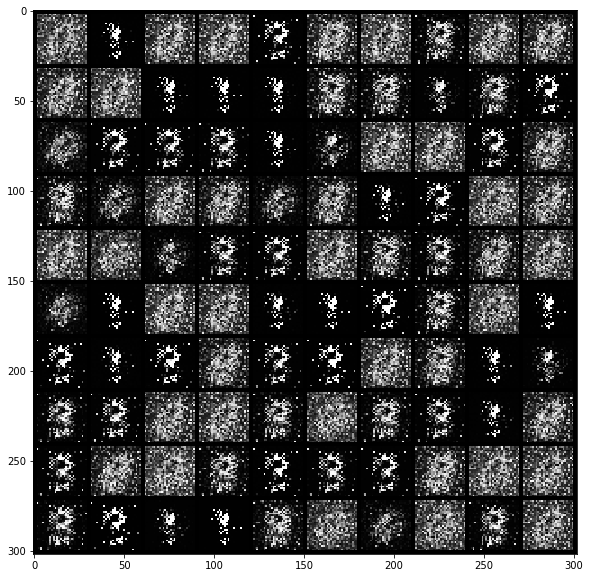

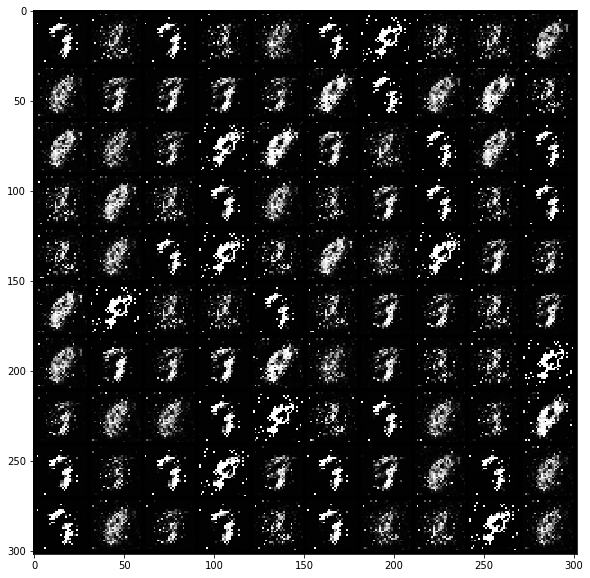

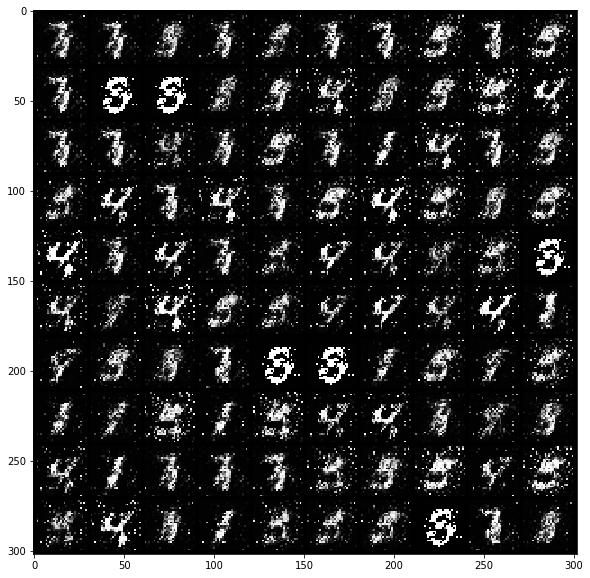

In [ ]:
img_indexes = [0, 4, 9, 49, 99] 
for i in img_indexes:
    plt.figure(figsize = (DIM, DIM))
    plt.imshow(saved_imgs[i], interpolation='nearest')

# Summary


*   GAN is very sensitive to hyperparameter -> highly unstable
*   Problem with output: generator learns 1 or 2 patterns and stops (here: generator creates almost only 1 or/and 9)
*   Low quality images

Useful links:
*   GAN Paper: https://arxiv.org/pdf/1406.2661.pdf
*   GAN explained, but the codes do not actually work: https://www.youtube.com/watch?v=OljTVUVzPpM&list=WL&index=39&t=765s


